In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 16 10:40:08 2015

@author: skh469
"""

import os
import json
from pprint import pprint

MOJO_DIR = os.path.join('data','boxofficemojo') 
META_DIR = os.path.join('data','metacritic') 
def get_movies(directory):
    '''Returns a list of dictionaries containing information in the
    JSON files of the provided directory, and prints the number
    of movies read'''
    file_contents = os.listdir(directory)
    movie_list=[]
    for filename in file_contents:
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as movie_file:
            movie_data = json.load(movie_file)
        if type(movie_data) == dict:
            movie_list.append(movie_data)
    print "Parsed %i movies from %i files" % (len(movie_list),
                                              len(file_contents))
    return movie_list
mojomovies=get_movies(MOJO_DIR)
metacriticmovies=get_movies(META_DIR)
from datetime import datetime

for movie in mojomovies:
    if movie['release_date_limited']:
        movie['release_date_limited']=datetime.strptime(movie['release_date_limited'],'%Y-%m-%d').date()
    if movie['release_date_wide']:
        movie['release_date_wide']=datetime.strptime(movie['release_date_wide'],'%Y-%m-%d').date()
import numpy as np
import pandas as pd

mojo_df = pd.DataFrame(mojomovies)
meta_df = pd.DataFrame(metacriticmovies)
meta_df['year']=meta_df['year'].replace('',np.nan)
meta_df=meta_df.sort('year')
meta_df=meta_df.dropna(subset=['title','year'],how='any')
mojo_df=mojo_df.dropna(subset=['title','year'],how='any')
meta_df['intyear']=[int(year) for year in meta_df['year']]
mojo_df['intyear']=[int(year) for year in mojo_df['year']]
import re,string
meta_df['char_title']= map(lambda x: re.sub('[\W_]+', '', x).upper(), meta_df['title'])
mojo_df['char_title']= map(lambda x: re.sub('[\W_]+', '', x).upper(), mojo_df['title'])
merged_df = pd.merge(meta_df, mojo_df, how='outer', on='char_title')


merged_df['intyear'] = merged_df['intyear_x'].fillna(merged_df['intyear_y'])

merged_df['director'] = merged_df['director_x'].fillna(merged_df['director_y'])

merged_df['international_gross']=merged_df['worldwide_gross']-merged_df['domestic_gross']
#merged_df['international_gross'].describe()

merged_df['ROI-total']=merged_df['worldwide_gross']/merged_df['production_budget']
merged_df['ROI-domestic']=merged_df['domestic_gross']/merged_df['production_budget']
merged_df['ROI-international']=merged_df['international_gross']/merged_df['production_budget']
merged_df['ROI-total'].describe()
merged_df['ROI-domestic'].describe()
merged_df['ROI-international'].describe()
merged_df['production_budget'].describe()
merged_df=merged_df.sort('ROI-total')

merged_df['dummy']=1
director_money=merged_df[['director','ROI-total','worldwide_gross']].groupby(['director']).mean()
director_count=merged_df[['director','dummy']].groupby(['director']).count()
director_money['director']=director_money.index
director_count['director']=director_count.index
director_merged = pd.merge(director_money, director_count, how='outer', on='director')
merged_df = pd.merge(merged_df, director_merged, how='outer', on='director')

merged_df = merged_df.drop(['director_x',
                            'director_y',
                            'intyear_x',
                            'intyear_y',
                            #'upper_title_x',
                            #'upper_title_y',
                            'year_x',
                            'year_y',
                            'complete',
                            'mojo_slug',
                            'dummy_x',
                            'complete',
                            'unable to retrieve',
                            'metacritic_page',
                            'alt_title'], 1)

pprint(merged_df.columns.values)
new_columns = ['genre', 'metascore', 'num_critic_reviews', 'num_user_ratings',
       'num_user_reviews', 'rating', 'release_date', 'runtime_minutes',
       'studio','title_meta', 'user_score', 'title', 'domestic_gross',
       'opening_per_theater', 'opening_weekend_take',
       'production_budget', 'release_date_limited', 'release_date_wide','title_mojo',
       'widest_release', 'worldwide_gross', 'intyear', 'director',
       'international_gross', 'ROI-total', 'ROI-domestic',
       'ROI-international', 'director_ROI-total', 'director_worldwide_gross', 'director_count']
merged_df.columns=new_columns

#john_carpenter_films=merged_df[merged_df.director == 'John Carpenter']

genres=list(merged_df['genre'].dropna())
genres2=set([item for sublist in genres for item in sublist])

#print len(genres2)

for genre in genres2:
    merged_df[genre]=map(lambda x: (type(x)==list) and (str(genre) in x), merged_df['genre'])

import re

merged_df['title_len']=map(len, merged_df['title'])
merged_df['title_words']=map(lambda x: len(x.split()), merged_df['title'])

merged_df.rating.value_counts()

rating_mapping={
'R':3,
'PG-13':2,
'Not Rated':3,
'PG':1,
'':3,
'nan':3,
'Unrated':3,
'G':0,
'TV-MA':3,
'NC-17':4,
'TV-14':2,
'TV-PG':1,
'TV-G':0,
'Approved':3,
'X':4,
'M':1,
'GP':1,
'PG--13':2,
'Passed':0,
'Open':0,
'TV-Y7':0,
'AO':4
}

merged_df['rating_num']=map(lambda x: rating_mapping[str(x)] ,merged_df['rating'])


ur_df = pd.read_csv('historical_unemp_rate.csv', index_col = 'Year')

ur_df = ur_df.stack()

ur_dic = dict(ur_df)

type(ur_dic.keys()[0])

ds_df = pd.read_csv('USDollarIndexTable.csv', index_col = 'DATE')
ds_dic = dict(ds_df.stack())

merged_df['release_date_yr_mth'] = zip(merged_df['release_date'].str[0:4], merged_df['release_date'].str[5:7])
merged_df['release_date_limited_yr_mth'] = zip(merged_df['release_date_limited'].str[0:4], merged_df['release_date_limited'].str[5:7])
merged_df['release_date_wide_yr_mth'] = zip(merged_df['release_date_wide'].str[0:4], merged_df['release_date_wide'].str[5:7])

list_keys = [item[0] for item in ds_dic.keys()]

def get_ds_year(strings):   
    year = strings[4:]
    if int(year) <20:
        year = '20'+year
    else:
        year = '19'+year
    return year

def get_ds_month(strings):
    month = strings[:3]
    if month == 'Jan': 
        month = '01'
    elif month == 'Feb': 
        month = '02'
    elif month == 'Mar': 
        month = '03'
    elif month == 'Apr': 
        month = '04'
    elif month == 'May':
        month = '05'
    elif month == 'Jun':
        month = '06'
    elif month == 'Jul':
        month = '07'
    elif month == 'Aug':
        month = '08'
    elif month == 'Sep':
        month = '09'
    elif month == 'Oct':
        month = '10'
    elif month == 'Nov':
        month = '11'
    elif month == 'Dec':
        month = '12'
    return month

list_new_keys = [(get_ds_year(key), get_ds_month(key)) for key in list_keys]

Parsed 3728 movies from 3728 files
Parsed 4765 movies from 4767 files
array([u'genre', u'metascore', u'num_critic_reviews', u'num_user_ratings',
       u'num_user_reviews', u'rating', u'release_date', u'runtime_minutes',
       u'studio', u'title_x', u'user_score', 'char_title',
       u'domestic_gross', u'opening_per_theater', u'opening_weekend_take',
       u'production_budget', u'release_date_limited', u'release_date_wide',
       u'title_y', u'widest_release', u'worldwide_gross_x', 'intyear',
       'director', 'international_gross', 'ROI-total_x', 'ROI-domestic',
       'ROI-international', 'ROI-total_y', u'worldwide_gross_y', 'dummy_y'], dtype=object)


In [2]:
%matplotlib inline

In [50]:
SciFi_movies = merged_df[merged_df['Sci-Fi']==1]
Crime_movies = merged_df[merged_df['Crime']==1]
Romance_movies = merged_df[merged_df['Romance']==1]
Animation_movies = merged_df[merged_df['Animation']==1]
Music_movies = merged_df[merged_df['Music']==1]
Adult_movies = merged_df[merged_df['Adult']==1]
Comedy_movies = merged_df[merged_df['Comedy']==1]
War_movies = merged_df[merged_df['War']==1]
Horror_movies = merged_df[merged_df['Horror']==1]
FilmNoir_movies = merged_df[merged_df['Film-Noir']==1]
Western_movies = merged_df[merged_df['Western']==1]
News_movies = merged_df[merged_df['News']==1]
Thriller_movies = merged_df[merged_df['Thriller']==1]
Adventure_movies = merged_df[merged_df['Adventure']==1]
Mystery_movies = merged_df[merged_df['Mystery']==1]
Short_movies = merged_df[merged_df['Short']==1]
Drama_movies = merged_df[merged_df['Drama']==1]
Action_movies = merged_df[merged_df['Action']==1]
Documentary_movies = merged_df[merged_df['Documentary']==1]
Musical_movies = merged_df[merged_df['Musical']==1]
History_movies = merged_df[merged_df['History']==1]
Family_movies = merged_df[merged_df['Family']==1]
Fantasy_movies = merged_df[merged_df['Fantasy']==1]
Sport_movies = merged_df[merged_df['Sport']==1]
Biography_movies = merged_df[merged_df['Biography']==1]

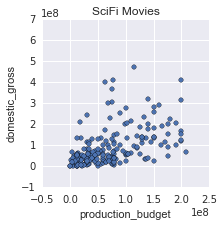

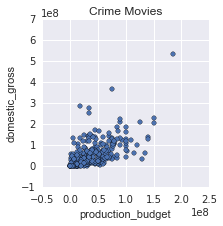

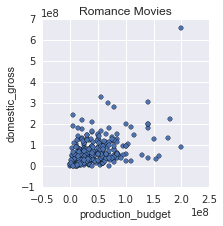

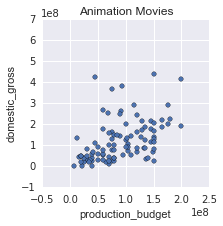

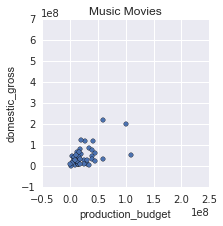

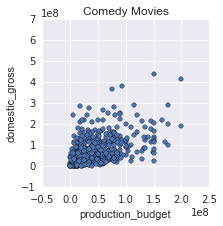

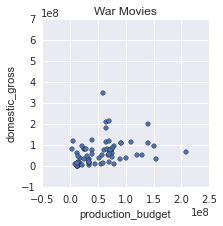

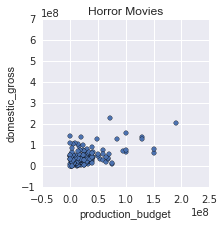

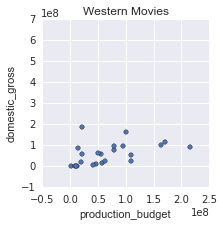

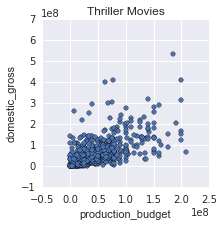

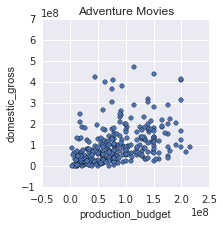

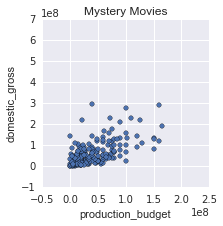

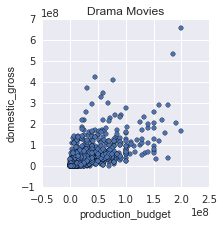

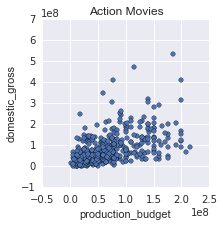

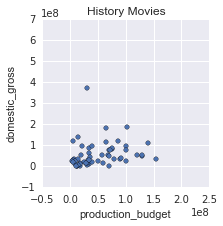

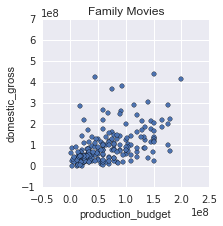

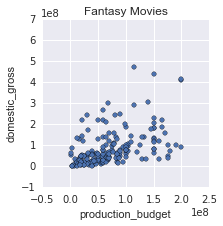

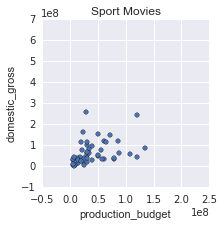

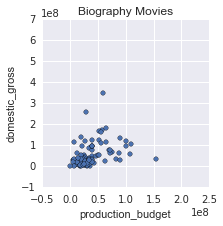

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

SciFi_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='SciFi Movies')
Crime_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Crime Movies')
Romance_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Romance Movies')
Animation_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Animation Movies')
Music_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Music Movies')
Comedy_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Comedy Movies')
War_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='War Movies')
Horror_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Horror Movies')
Western_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Western Movies')
Thriller_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Thriller Movies')
Adventure_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Adventure Movies')
Mystery_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Mystery Movies')
Drama_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Drama Movies')
Action_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Action Movies')
History_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='History Movies')
Family_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Family Movies')
Fantasy_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Fantasy Movies')
Sport_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Sport Movies')
Biography_movies.plot(kind='scatter', x='production_budget', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),2.5*(10**8)], title='Biography Movies')

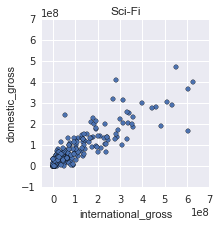

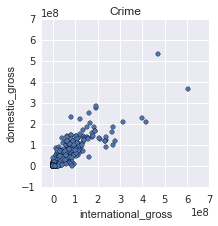

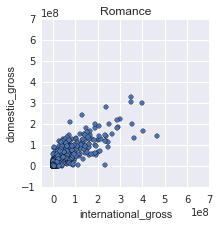

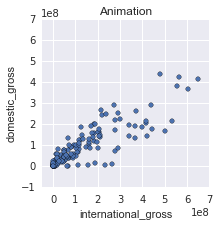

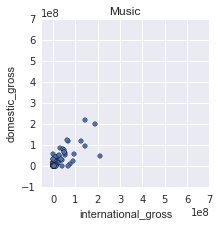

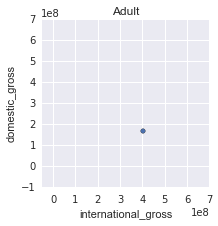

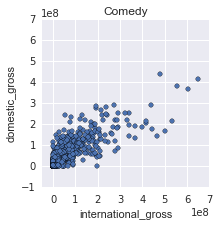

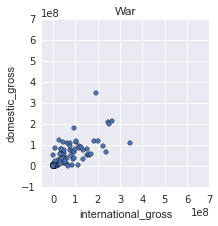

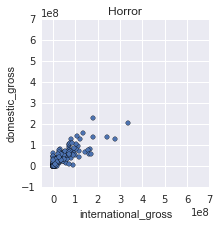

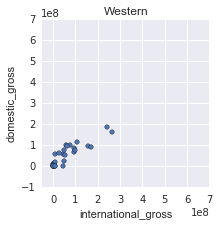

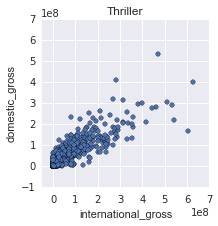

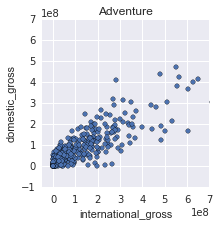

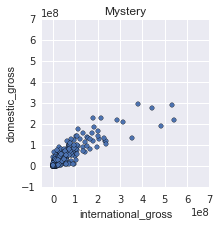

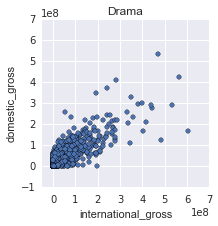

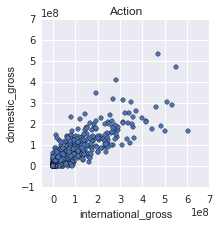

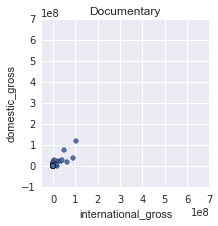

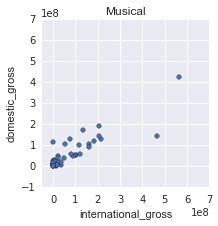

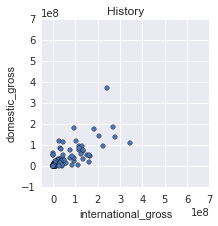

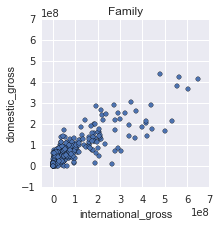

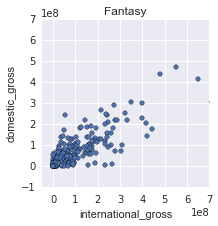

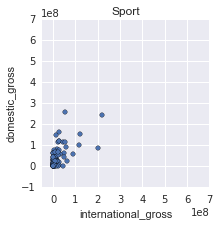

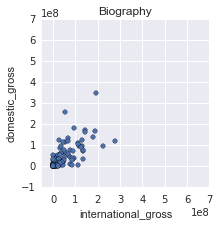

In [59]:
SciFi_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Sci-Fi')
Crime_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Crime')
Romance_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Romance')
Animation_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Animation')
Music_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Music')
Comedy_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Comedy')
War_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='War')
Horror_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Horror')
Western_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Western')
Thriller_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Thriller')
Adventure_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Adventure')
Mystery_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Mystery')
Drama_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Drama')
Action_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Action')
Documentary_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Documentary')
Musical_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Musical')
History_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='History')
Family_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Family')
Fantasy_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Fantasy')
Sport_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Sport')
Biography_movies.plot(kind='scatter', x='international_gross', y='domestic_gross', figsize=(3,3),ylim=[-(10**8),7*(10**8)], xlim=[-0.5*(10**8),7*(10**8)], title='Biography')